In [1]:
import random

import numpy as np
import pandas as pd

from dataset import get_gender_dataset
from trainer import Trainer
from inference import create_label, sum_label
from loss import LabelSmoothing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

In [2]:
## seeds

random_seed = 42

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
## hyperparameters

model_name = 'efficientnet-b0'
batch_size = 64
lr = 0.00006
num_epoch = 40
target = 'gender'
split = 20

df_ff_path = f'/opt/ml/code/df/df_ff_all_race.csv'
df_train_path = f'/opt/ml/code/df/df_mask_gender_train_{split}.csv'
df_valid_path = f'/opt/ml/code/df/df_mask_gender_valid_{split}.csv'
#df_test_path = '/opt/ml/input/data/eval/info.csv'

In [4]:
## prepare dataset

df_ff = pd.read_csv(df_ff_path)
df_train = pd.read_csv(df_train_path)
df_valid = pd.read_csv(df_valid_path)

train_dataset, valid_dataset = get_gender_dataset(df_ff, df_train, df_valid, target=target)

In [5]:
## prepare sampler

from torch.utils.data.sampler import WeightedRandomSampler

weight1 = df_ff.gender.value_counts().sort_index().to_numpy()
weight2 = df_train[target].value_counts().sort_index().to_numpy() 
print('count :', weight1, weight2)
weight1 = 1. / weight1
weight2 = 1. / weight2
samples_weight = np.array([weight1[t] for t in df_ff[target]] + [weight2[t] for t in df_train[target]])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight)//2)

count : [4823 5320] [5810 9310]


In [6]:
## prepare Dataloader

dataloaders = {'train' : DataLoader(train_dataset, batch_size=batch_size, num_workers=3, drop_last=True, sampler=sampler),
               'valid' : DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=3, drop_last=False)}

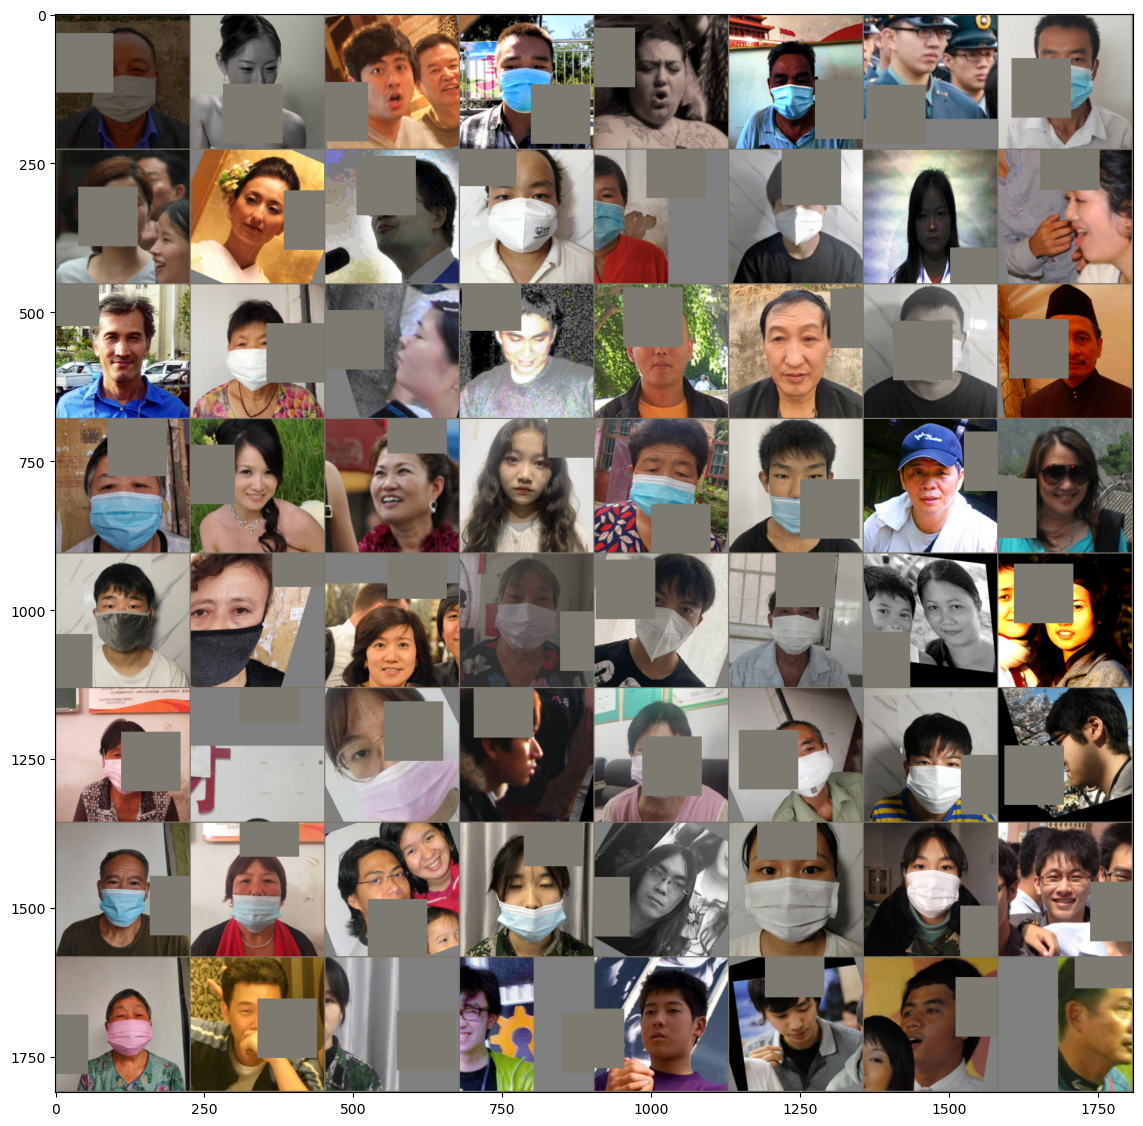

tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])


In [7]:
# check input train batch
a = iter(dataloaders['train'])
from utils import imshow
for i in range(4):
    batch = next(a)
imshow(batch[0])
print(batch[1])

In [8]:
## prepare model

device = 'cuda'

if model_name.startswith('efficientnet'):
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained(model_name, num_classes=2)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
    
model.to(device)
print(model_name, 'ready')

Loaded pretrained weights for efficientnet-b0
efficientnet-b0 ready


In [9]:
criterion = LabelSmoothing(0.05)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = None #optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma = 0.2)

## Train

In [10]:
trainer = Trainer('/opt/ml/code/save')

In [11]:
## resume
# model.load_state_dict(torch.load('/opt/ml/code/save/label/effnet_test018.pt'))

# # change lr manually:
# for g in optimizer.param_groups:
#     g['lr'] = 0.00001

In [12]:
trainer.train(model, dataloaders, criterion, optimizer, device, num_epochs=num_epoch, scheduler=lr_scheduler,
              sub_dir='gender_extened', save_name='epoch_')

Epoch 1/40
----------


100%|██████████| 197/197 [00:54<00:00,  3.59it/s]


train Loss: 0.4379 Acc: 0.8248 F1: 0.8247829784794658


100%|██████████| 60/60 [00:07<00:00,  7.64it/s]


valid Loss: 0.2038 Acc: 0.9598 F1: 0.9574730009512618

Epoch 2/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.53it/s]


train Loss: 0.3096 Acc: 0.8985 F1: 0.8984467964902305


100%|██████████| 60/60 [00:07<00:00,  7.73it/s]


valid Loss: 0.1776 Acc: 0.9735 F1: 0.9721079237404071

Epoch 3/40
----------


100%|██████████| 197/197 [00:54<00:00,  3.62it/s]


train Loss: 0.2758 Acc: 0.9167 F1: 0.9167179001556935


100%|██████████| 60/60 [00:07<00:00,  7.65it/s]


valid Loss: 0.1702 Acc: 0.9772 F1: 0.9759760558696375

Epoch 4/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.57it/s]


train Loss: 0.2522 Acc: 0.9292 F1: 0.929161793487852


100%|██████████| 60/60 [00:07<00:00,  7.72it/s]


valid Loss: 0.1606 Acc: 0.9815 F1: 0.9805049612884231

Epoch 5/40
----------


100%|██████████| 197/197 [00:54<00:00,  3.58it/s]


train Loss: 0.2419 Acc: 0.9362 F1: 0.9361513987084595


100%|██████████| 60/60 [00:07<00:00,  7.71it/s]


valid Loss: 0.1599 Acc: 0.9844 F1: 0.9836108401263248

Epoch 6/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.57it/s]


train Loss: 0.2307 Acc: 0.9434 F1: 0.9433684685192492


100%|██████████| 60/60 [00:07<00:00,  7.64it/s]


valid Loss: 0.1621 Acc: 0.9807 F1: 0.9796154324340677

Epoch 7/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.53it/s]


train Loss: 0.2246 Acc: 0.9465 F1: 0.9465011203687521


100%|██████████| 60/60 [00:07<00:00,  7.62it/s]


valid Loss: 0.1529 Acc: 0.9862 F1: 0.9855394500223795

Epoch 8/40
----------


100%|██████████| 197/197 [00:54<00:00,  3.63it/s]


train Loss: 0.2195 Acc: 0.9488 F1: 0.9487606273926229


100%|██████████| 60/60 [00:07<00:00,  7.72it/s]


valid Loss: 0.1541 Acc: 0.9839 F1: 0.982992282798108

Epoch 9/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.55it/s]


train Loss: 0.2150 Acc: 0.9515 F1: 0.9514592919259488


100%|██████████| 60/60 [00:07<00:00,  7.65it/s]


valid Loss: 0.1604 Acc: 0.9799 F1: 0.9787420452863698

Epoch 10/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.57it/s]


train Loss: 0.2072 Acc: 0.9568 F1: 0.9567727132911218


100%|██████████| 60/60 [00:07<00:00,  7.70it/s]


valid Loss: 0.1519 Acc: 0.9870 F1: 0.9863787179712893

Epoch 11/40
----------


100%|██████████| 197/197 [00:54<00:00,  3.60it/s]


train Loss: 0.2050 Acc: 0.9554 F1: 0.9554206746264959


100%|██████████| 60/60 [00:07<00:00,  7.73it/s]


valid Loss: 0.1496 Acc: 0.9884 F1: 0.9877490265219728

Epoch 12/40
----------


100%|██████████| 197/197 [00:55<00:00,  3.55it/s]


train Loss: 0.1983 Acc: 0.9613 F1: 0.9612917824760521


100%|██████████| 60/60 [00:07<00:00,  7.74it/s]


valid Loss: 0.1517 Acc: 0.9862 F1: 0.9855323315881255

Epoch 13/40
----------


 29%|██▉       | 58/197 [00:16<00:40,  3.47it/s]


KeyboardInterrupt: 

## Experiment Logs

---

## Gender(Extended) Experiment Logs

---

1. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 53)
      - train Loss: 0.1424 Acc: 0.9878 F1: 0.9877829872469728
      - valid Loss: 0.1475 Acc: 0.9897 F1: 0.9891505862856257
      - fixed valid        Acc: 0.9915 F1: 0.9911055553512997   

2. model=eff b3, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=300, loss_fn=LS(0.05), fixed, split 20%
    * epoch 06)
      - train Loss: 0.1799 Acc: 0.9688 F1: 0.968828211679331
      - valid Loss: 0.1401 Acc: 0.9926 F1: 0.9922154582288432     

3. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=cifar10+cutout, inputsize=300, loss_fn=LS(0.05), fixed, split 20%
    * epoch 33)
      - train Loss: 0.1631 Acc: 0.9768 F1: 0.9768299427193199
      - valid Loss: 0.1440 Acc: 0.9897 F1: 0.9891505862856258

---

## Gender Experiment Logs

---

1. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 18)
      - train Loss: 0.1446 Acc: 0.9881 F1: 0.9880777974235919
      - valid Loss: 0.1551 Acc: 0.9854 F1: 0.9846651730146876
        
2. model=eff b0, optimizer=Adam, lr=0.0003, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 15)
      - train Loss: 0.1371 Acc: 0.9911 F1: 0.9911258239235885
      - valid Loss: 0.1574 Acc: 0.9868 F1: 0.9860680087572518
---
3. model=eff b0, optimizer=Adam, lr=0.0003, bs=64, augment=randaug+cutout, inputsize=224, crop=224, loss_fn=LS(0.05), split 20%
    * epoch 09)
      - train Loss: 0.1574 Acc: 0.9799 F1: 0.9798725637365424
      - valid Loss: 0.1556 Acc: 0.9820 F1: 0.9810713788113145
---
4. model=eff b0, optimizer=Adam, lr=0.0003, bs=64, augment=randaug+cutout, inputsize=224, crop=280, loss_fn=LS(0.05), split 20%
    * epoch 09)
      - train Loss: 0.1574 Acc: 0.9799 F1: 0.9798725637365424
      - valid Loss: 0.1556 Acc: 0.9820 F1: 0.9810713788113145

### loss function test

---

1. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=CE, WeightedSampler, split 25%, optimizer=Adam
   * epoch 18)
     - train Loss: 0.0991 Acc: 0.9655 F1: 0.9654261306812848
     - valid Loss: 0.0980 Acc: 0.9778 F1: 0.9772288369633227  
  * before first patience

---

2. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=LS(0.05), WeightedSampler, split 25%, optimizer=Adam
    * epoch 21)
     - train Loss: 0.3310 Acc: 0.9638 F1: 0.963728513759618
     - valid Loss: 0.3071 Acc: 0.9786 F1: 0.9791634664746235 

---

3. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=F1_Loss, split 25%, optimizer=Adam
   * epoch 13)
     - train Loss: 0.0710 Acc: 0.9584 F1: 0.9476713834498373
     - valid Loss: 0.0403 Acc: 0.9765 F1: 0.9748789208889367
   * epoch 3)
     - train Loss: 0.0594 Acc: 0.9655 F1: 0.9555452013464937
     - valid Loss: 0.0369 Acc: 0.9782 F1: 0.9776768545260203

---

### split ratio test

---

4. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 15%
    * epoch 21)
      - train Loss: 0.3381 Acc: 0.9597 F1: 0.9597144587078792
      - valid Loss: 0.2948 Acc: 0.9852 F1: 0.982564296238198
      
---

5. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 27)
      - train Loss: 0.3211 Acc: 0.9668 F1: 0.9668728849468181
      - valid Loss: 0.2878 Acc: 0.9854 F1: 0.9842203787970396
      
---

6. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 25%
    * epoch 22)
      - train Loss: 0.3321 Acc: 0.9639 F1: 0.9638739223128628
      - valid Loss: 0.2910 Acc: 0.9829 F1: 0.9792575649184908
      
---

7. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 30%
    * epoch 29)
      - train Loss: 0.3171 Acc: 0.9686 F1: 0.9685813478405522
      - valid Loss: 0.3047 Acc: 0.9772 F1: 0.9764751322879572

## Debug

In [35]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from torch.nn.functional import softmax

model.load_state_dict(torch.load('/opt/ml/code/save/gender_extened/log1_2.pt'))
model.eval()

y_true = []
y_pred = []
wrong = []
prob = []

for inputs, labels in dataloaders['valid']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        pr = softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        wrong_idx = np.nonzero(y_true != y_pred)
        prob.append(pr[wrong_idx].cpu().numpy())
        for p, t, inp in zip(preds, labels, inputs):
            if p.item() != t.item():
                wrong.append((inp.cpu().numpy(), p.item(), t.item()))
                
prob = np.concatenate(prob)
mtx = confusion_matrix(y_true, y_pred)

print(mtx)
print(f1_score(y_true, y_pred, average='macro'), accuracy_score(y_true, y_pred))

[[1459   11]
 [  21 2289]]
0.9911055553512997 0.9915343915343915


In [36]:
import pickle

d = {'y_pred':y_pred, 'y_true':y_true}

with open('gender_pred.pkl', 'wb') as f:
    pickle.dump(d, f)

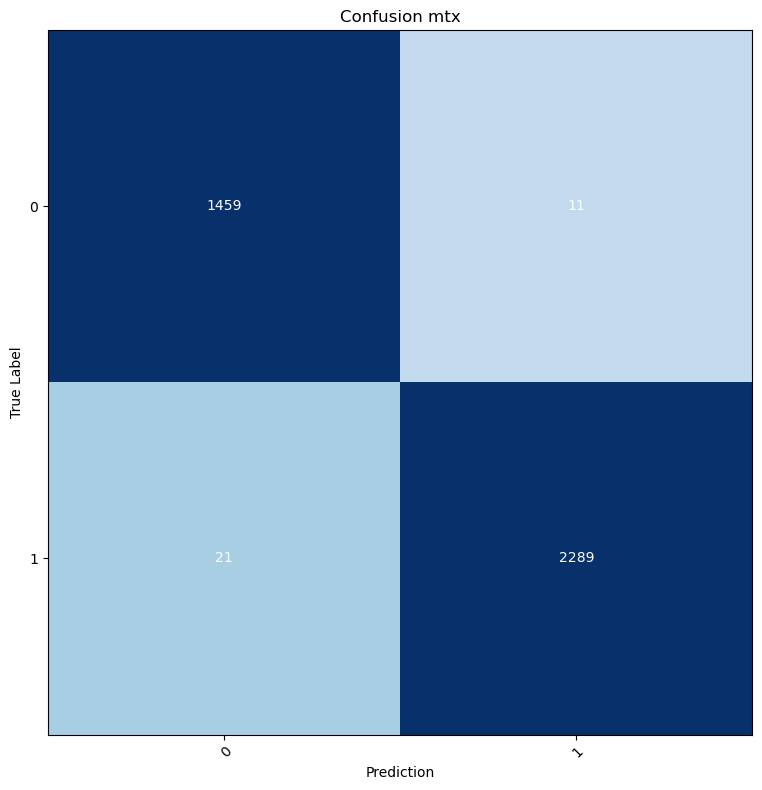

In [20]:
import matplotlib.pyplot as plt

label_ = list(range(2))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(mtx, cmap='Blues', vmax=100, vmin=-20)

ax.set_xticks(np.arange(len(label_)))
ax.set_yticks(np.arange(len(label_)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_)
ax.set_yticklabels(label_)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_)):
    for j in range(len(label_)):
        if mtx[i, j]:
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center", color="w", size=10)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')
ax.set_title("Confusion mtx")
fig.tight_layout()
plt.show()

In [31]:
import matplotlib.pyplot as plt
iterator = iter(wrong)

label = ["Male", "Female"]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

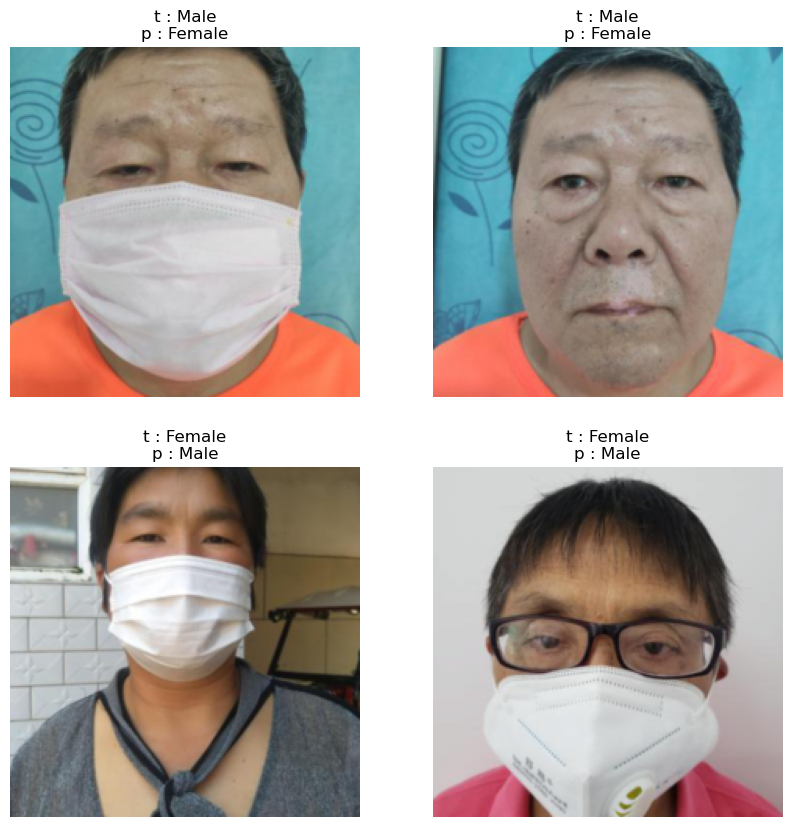

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax in axes.flatten():
    img, p, t = next(iterator)
    img = img.transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f't : {label[t]}\np : {label[p]}')
plt.show()

## Inference

In [ ]:
def sum_label(df):
    
    def _label(row):
        return row['age'] + 3*row['label']# + 6*row['mask']

    df['ans'] = df.apply(_label, axis=1)
    return df[['ImageID', 'ans']]

In [ ]:
## inference

# model.load_state_dict(torch.load('/opt/ml/code/save/best_log2.pt'))
# df_submit = create_label(model, test_dataloader, df_test.copy(), device, target='label')

# model = EfficientNet.from_pretrained(model_name, num_classes=3).to(device)
# model.load_state_dict(torch.load('/opt/ml/code/save/age/extended_far_best.pt'))
# df_submit = create_label(model, test_dataloader, df_submit, device, target='age')

# model.load_state_dict(torch.load('/opt/ml/code/save/mask/6e5_9987.pt'))
# df_submit = create_label(model, test_dataloader, df_submit, device, target='mask')

# model.fc = nn.Linear(model.fc.in_features, 2).cuda()
# model.load_state_dict(torch.load('/opt/ml/code/save/gender/6e5_9851.pt'))
# df_submit = create_label(model, test_dataloader, df_submit, device, target='gender')


# df_submit = sum_label(df_submit)
# df_submit


df_submit.to_csv('submit.csv', index=False)